# Inference notenook for [CLIP prefix captioning](https://github.com/rmokady/CLIP_prefix_caption/)

Disclaimer: the authors do not own any rights for the code or data.

In [20]:
#@title Install
!pip install transformers
! pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-38vz4v3k
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-38vz4v3k
  Resolved https://github.com/openai/CLIP.git to commit d50d76daa670286dd6cacf3bcd80b5e4823fc8e1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=2ad92c294317b835c58115d834d3aa2084aceaf6fb4eebbfdd66915617a1e5c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-gvsubnzg/wheels/c8/e4/e1/11374c111387672fc2068dfbe0d4b424cb9cdd1b2e184a71b5
Successfully built clip
  Attempting uninstall: clip
    Found existing installation: clip 0.2.0
    Uninstalling clip-0.2.0:
      Successfully uninstalled clip-0.2.0


In [1]:
#@title Drive Downloader

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

download_with_pydrive = False #@param {type:"boolean"}  

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

#         if self.use_pydrive:
#             self.authenticate()
        
    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)
    
    def download_file(self, file_id, file_dst):
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)

In [2]:
#@title Imports
import sys
sys.path.insert(0, '/data/data/fairclip/')
import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
# from google.colab import files
import skimage.io as io
import PIL.Image
from IPython.display import Image 


N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device(0)

current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
os.makedirs(save_path, exist_ok=True)
model_path = os.path.join(save_path, 'model_wieghts.pt')


In [3]:
#@title Model

class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [4]:
#@title Caption prediction

def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list

In [5]:
#@title Choose pretrained model - COCO or Coneptual captions


pretrained_model = 'COCO'  # @param ['COCO', 'Conceptual captions']

if pretrained_model == 'Conceptual captions':
  downloader.download_file("14pXWwB4Zm82rsDdvbGguLfx9F8aM7ovT", model_path)
else:
  downloader.download_file("1IdaBtMSvtyzF0ByVaBHtvM0JYSXRExRX", model_path)

/opt/conda/envs/pytorch/lib/python3.9/site-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1IdaBtMSvtyzF0ByVaBHtvM0JYSXRExRX
To: /data/data/fairclip/CLIP_prefix_caption/pretrained_models/model_wieghts.pt
100%|████████████████████████████████████████| 636M/636M [00:06<00:00, 97.3MB/s]


In [6]:
#@title GPU/CPU


is_gpu = True #@param {type:"boolean"}  


In [10]:
# clip

In [7]:
#@title CLIP model + GPT2 tokenizer

device = CUDA if is_gpu else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [8]:
#@title Load model weights
print(model_path)

prefix_length = 10

model = ClipCaptionModel(prefix_length)

model.load_state_dict(torch.load(model_path, map_location=CPU)) 

model = model.eval() 
device = CUDA if is_gpu else "cpu"
model = model.to(device)


/data/data/fairclip/CLIP_prefix_caption/pretrained_models/model_wieghts.pt


In [16]:
#@title Upload Image


# uploaded = files.upload()

# if not uploaded:
#   UPLOADED_FILE = ''
# elif len(uploaded) == 1:
#   UPLOADED_FILE = list(uploaded.keys())[0]
# else:
#   raise AssertionError('Please upload one image at a time')

# print(UPLOADED_FILE)

In [20]:
#@title Or download random samples form COCO test set (Karpathy et al. split)

# IMAGE_NAME = '386164'  # @param ['562207', '579664', '060623', '165547', '334321', '483108', '386164', '354533']

# name_ = "COCO_val2014_000000" + IMAGE_NAME + ".jpg"
# images_path = os.path.join(os.path.dirname(current_directory), "images")
# os.makedirs(images_path, exist_ok=True)
# UPLOADED_FILE = os.path.join(images_path, name_)

# if not os.path.isfile(UPLOADED_FILE):
#   download_path = os.path.join(images_path, "images.zip")
#   downloader.download_file("1BwJeBME-dpwcCT8IXYeWz7uaPkbexjNB", download_path)

#   !unzip {download_path} -d {images_path}



Conceptual captions examples:
https://drive.google.com/file/d/1mzH3b0LQrGEWjEva4hI6HE_fIYRIgtBT/view?usp=sharing

In [9]:
# occupations 
import pandas as pd
gender_labels = pd.read_csv('/data/data/fairclip/gender_labelled_images.csv', index_col = None)

In [10]:
gender_labels

,search_term,bls_n,bls_women,search_n,search_women,bls_p_women,search_p_women,Answer.typeofpeople,Answer.howmany,multiple_onegender,image_gender,image_url,source_url,order,search_provider
0,administrative assistant,2904000,2767512,78,72,0.953,0.923077,woman,oneperson,False,woman,http://homes.cs.washington.edu/~mjskay/aws-ima...,http://www.google.com/imgres?biw=1141&bih=508&...,0,google
1,announcer,50000,11800,86,18,0.236,0.209302,man,oneperson,False,man,http://homes.cs.washington.edu/~mjskay/aws-ima...,http://www.google.com/imgres?biw=1141&bih=508&...,0,google
2,author,208000,115648,65,16,0.556,0.246154,man,oneperson,False,man,http://homes.cs.washington.edu/~mjskay/aws-ima...,http://www.google.com/imgres?biw=1141&bih=508&...,0,google
3,bartender,412000,246788,94,22,0.599,0.234043,man,oneperson,False,man,http://homes.cs.washington.edu/~mjskay/aws-ima...,http://www.google.com/imgres?biw=1141&bih=508&...,0,google
4,biologist,101000,50601,65,23,0.501,0.353846,man,oneperson,False,man,http://homes.cs.washington.edu/~mjskay/aws-ima...,http://www.google.com/imgres?biw=1141&bih=508&...,0,google
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,primary school teacher,2838000,2310132,78,56,0.814,0.717949,man|child,multiple,True,man,http://homes.cs.washington.edu/~mjskay/aws-ima...,http://www.google.com/imgres?biw=1141&bih=508&...,99,google
3258,security guard,903000,167055,95,5,0.185,0.052632,man,oneperson,False,man,http://homes.cs.washington.edu/~mjskay/aws-ima...,http://www.google.com/imgres?biw=1141&bih=508&...,99,google
3259,software developer,1084000,213548,81,12,0.197,0.148148,woman,oneperson,False,woman,http://homes.cs.washington.edu/~mjskay/aws-ima...,http://www.google.com/imgres?biw=1141&bih=508&...,99,google
3260,special ed teacher,366000,315492,86,67,0.862,0.779070,woman,multiple,True,woman,http://homes.cs.washington.edu/~mjskay/aws-ima...,http://www.google.com/imgres?biw=1141&bih=508&...,99,google


In [11]:
gender_labels['image_gender'].value_counts()

man      1992
woman    1270
Name: image_gender, dtype: int64

In [83]:
gender_labels['search_term'].value_counts().index

Index(['chief executive officer', 'security guard', 'bartender', 'chef',
       'telemarketer', 'nurse', 'construction worker', 'lab tech', 'announcer',
       'special ed teacher', 'plumber', 'insurance sales agent', 'doctor',
       'housekeeper', 'software developer', 'receptionist',
       'customer service representative', 'cook', 'primary school teacher',
       'pharmacist', 'nurse practitioner', 'administrative assistant',
       'chemist', 'pilot', 'electrician', 'roofer', 'mail carrier',
       'truck driver', 'police officer', 'childcare worker', 'engineer',
       'optician', 'librarian', 'biologist', 'author', 'custodian', 'butcher',
       'building inspector', 'computer programmer', 'bus driver',
       'crane operator', 'technical writer', 'garbage collector', 'drafter',
       'welder'],
      dtype='object')

2368 gender:  woman profession:  author


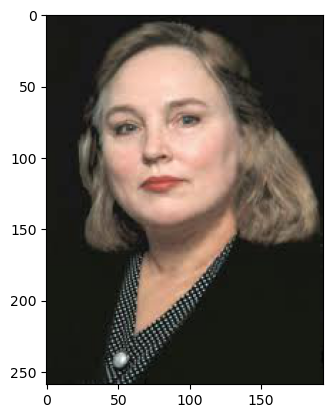

In [13]:
import random
import skimage.io as io
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import Image

i = random.randint(0,len(gender_labels))

print(i , "gender: ", gender_labels.iloc[i]['image_gender'], 'profession: ', gender_labels.iloc[i]['search_term'])
# print(captions[idx][0])
# print(mycoco_orig[idx][2])
# plt.imshow(mycoco_orig[idx][0])
#%08d.xml" % (idx+1,)
image = io.imread(f"/data/data/fairclip/google/{gender_labels.iloc[i]['search_term']}/{gender_labels.iloc[i]['order']}.jpg")
pil_image = PIL.Image.fromarray(image)
plt.imshow(pil_image)

0 12 gender:  woman profession:  software developer


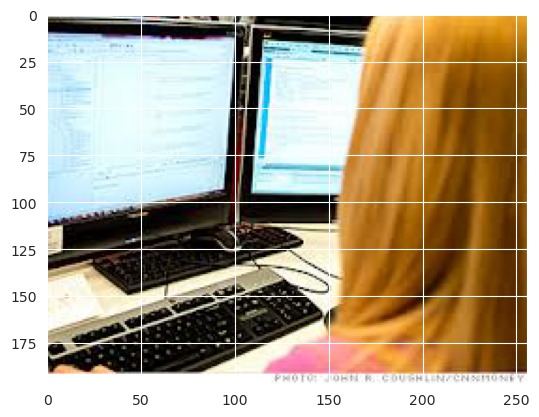

1 12 gender:  woman profession:  software developer


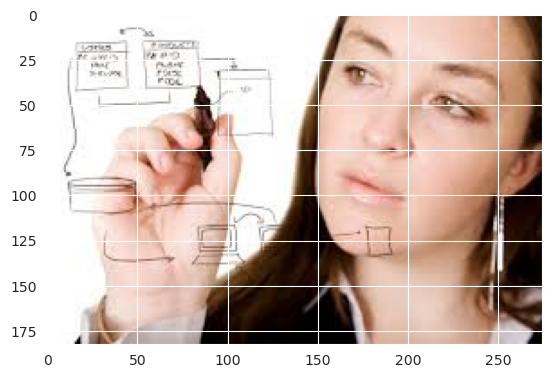

2 12 gender:  woman profession:  software developer


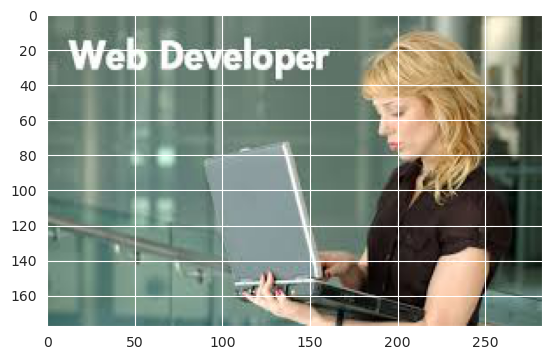

3 12 gender:  woman profession:  software developer


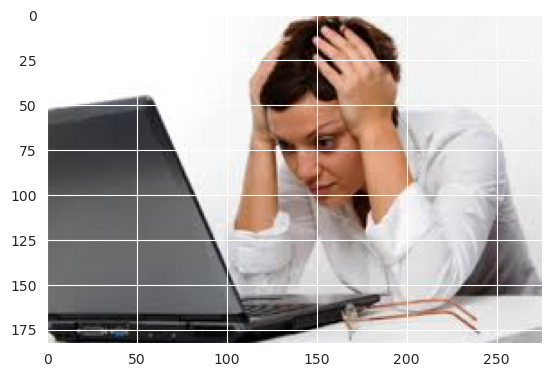

4 12 gender:  woman profession:  software developer


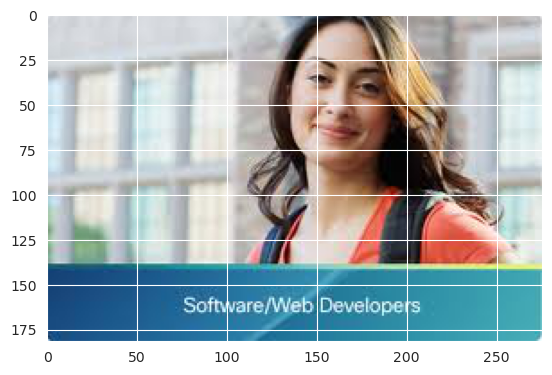

5 12 gender:  woman profession:  software developer


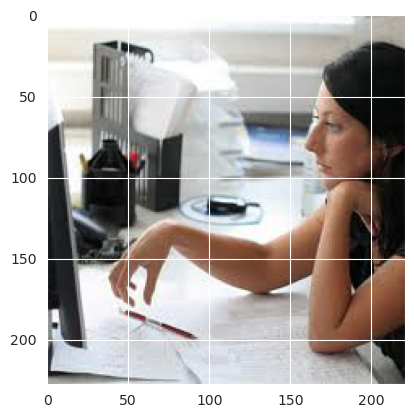

6 12 gender:  woman profession:  software developer


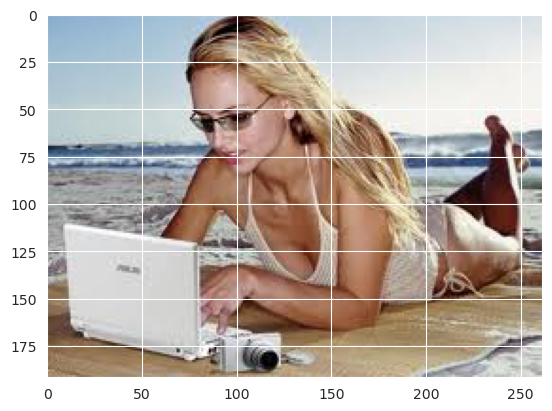

7 12 gender:  woman profession:  software developer


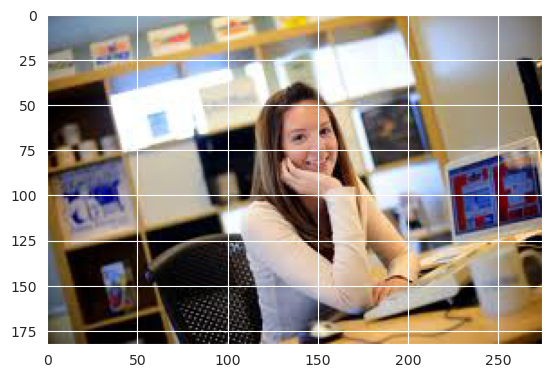

8 12 gender:  woman profession:  software developer


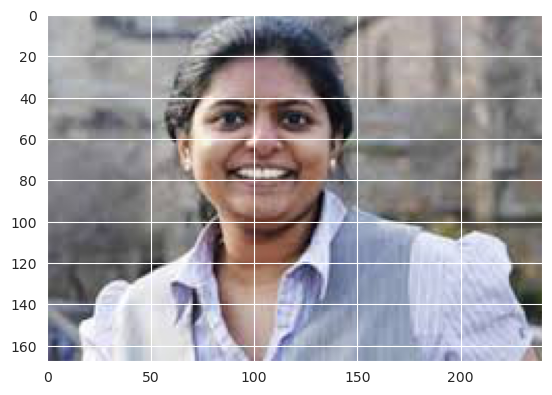

9 12 gender:  woman profession:  software developer


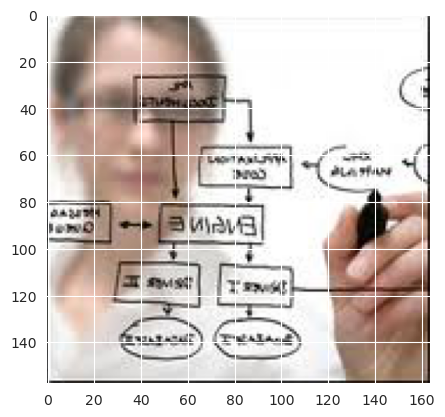

10 12 gender:  woman profession:  software developer


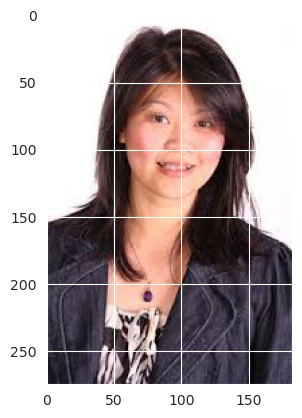

11 12 gender:  woman profession:  software developer


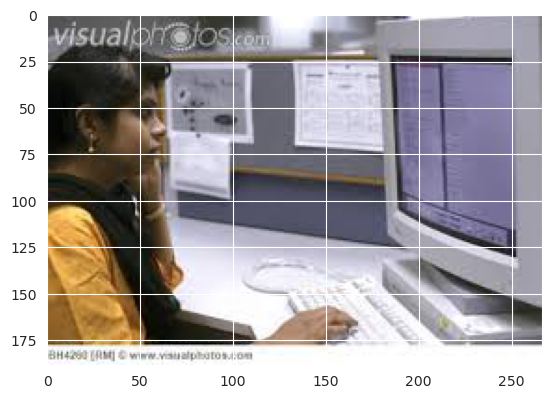

In [290]:
# random in certain profession 
import random
import skimage.io as io
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import Image

temp = gender_labels[(gender_labels['search_term'] == 'software developer')& (gender_labels['image_gender'] == 'woman')]
# if True:
for i in range(len(temp)):
#     i = random.randint(0,len(temp)-1)
# i = 97
    print(i , len(temp), "gender: ", temp.iloc[i]['image_gender'], 'profession: ', temp.iloc[i]['search_term'])
    # print(captions[idx][0])
    # print(mycoco_orig[idx][2])
    # plt.imshow(mycoco_orig[idx][0])
    #%08d.xml" % (idx+1,)
    order = temp.iloc[i]['order']
    # order = 27
    image = io.imread(f"/data/data/fairclip/google/{temp.iloc[i]['search_term']}/{order}.jpg")
    pil_image = PIL.Image.fromarray(image)
    plt.imshow(pil_image)
    plt.show()

In [240]:
len(gender_labels[(gender_labels['search_term'] == 'optician') & (gender_labels['image_gender'] == 'man')])

22

In [1]:
# generate captions google images  
import pickle 
with open(f'generated_captions_google.pickle', 'rb') as f:
        captions_google = pickle.load(f)

# captions_google = {}
# for i in range(len(gender_labels)):
    
    
# #     gender = gender_labels.iloc[i]['image_gender'][ix]
    
    
# #     if (gender != 'Male' and gender != 'Female') or (race != 'Light' and race != 'Dark'):
# #         print(gender, race, gender != 'Male')
# #         continue
    
#     image = io.imread(f"/data/data/fairclip/google/{gender_labels.iloc[i]['search_term']}/{gender_labels.iloc[i]['order']}.jpg")
#     pil_image = PIL.Image.fromarray(image)
#     image =preprocess(pil_image).unsqueeze(0).to(device)

#     with torch.no_grad():
#         prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)

#         prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
    
#         captions_google[f"{gender_labels.iloc[i]['search_term']}/{gender_labels.iloc[i]['order']}"] = generate2(model, tokenizer, embed=prefix_embed)

In [ ]:
# import pickle

# with open('generated_captions_google.pickle', 'wb') as handle:
#     pickle.dump(captions_google, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [2]:
# search_terms = list(gender_labels['search_term'].value_counts().index)
professions = {
#   "chief executive officer": ["chief", "executive", "officer", "CEO"],
#    "security guard" : ["security", "guard"],
    "bartender" : ["bartender", "glass", "wine", "bar"],
    'chef' : ["chef", "cook", 'kitchen', "chef's", "wearing", "white", "outfit"],
    'telemarketer': ["telemarketer", "secretary", "phone", "cell", "talking", "headphones"],    
    'nurse': ['doctor', 'nurse', 'medicine', 'medical', 'device', 'hospital', 'patient', 'lab', 'coat', 'gown'],
#     'construction worker': ['construction', 'worker', 'labourer'],
    'lab tech': ['lab', 'tech', 'lab', 'coat'],# 'experiment', 'medical'],
    'announcer': ['announcer', 'phone', 'microphone'],
    'special ed teacher': ['teacher', 'wearing'],
#     'plumber':['plumber'], 
    'insurance sales agent':['salesperson', 'salesman'], 
    'doctor': ['doctor', 'nurse', 'medicine', 'medical','device', 'hospital', 'patient', 'lab', 'coat', 'gown'],
#     'housekeeper': ['housekeeper','cleaner'],
    'software developer': ['computer','laptop'],
#     'receptionist': ['secretary', 'receptionist'],
    'customer service representative': ['telemarketer', 'secretary', 'talking', 'wearing', 'headset', 'cell',
                                        'phone', 'headphones'], 
    'cook': ["chef", 'cook', 'kitchen', "chef's", "wearing", "white", "outfit"], 
    'primary school teacher':['teacher', 'teaching', 'wearing', 'children'],
    'pharmacist':['pharmacist',  'doctor',  'lab', 'coat'],
    'nurse practitioner': ['doctor', 'nurse', 'medicine', 'medical','device', 'hospital', 'patient', 'lab', 'coat', 'gown'],
#     'administrative assistant': ['secretary', 'assistant', 'boss'],
    'chemist':['chemist', 'scientist', 'medical', 'lab', 'coat', 'gown'],
#     'pilot': ['pilot', 'airplane', 'plane'], # 
#     'electrician':['electrician'],
#     'roofer':['worker', 'construction', 'worker', 'roofer'],
    'mail carrier': ['mail', 'carrier', 'postman', 'paper'],
#     'truck driver':['truck driver', 'driver'],
    'police officer':['police', 'officer', 'uniform'],
#     'childcare worker':['childcare','worker', 'mother', 'father', 'nanny'],
    'engineer': ['engineer'],
    'optician':['optician', 'eye','glasses', 'lab'],
#     'librarian': ['librarian'],
    'biologist': ['biologist', 'white', 'coat', 'doctor', 'gown','lab'],
    'author': ['author', 'book'],
#     'custodian': ['custodian', 'cleaner', 'janitor'],
#     'butcher' : ['butcher'],
#     'building inspector':['building', 'inspector', 'architect', 'engineer'],
    'computer programmer': ['computer', 'laptop'],
#     'bus driver': ['diver', 'bus driver'],
#        'crane operator': ['crane', 'operator', 'diver'],
#     'technical writer': ['author', 'writer'],
#     'garbage collector':['garbage', 'collector', 'janitor'],
#     'drafter': ['drafter', 'architect'],
#        'welder' : ['welder']
       
}
# to_be_merged = {"chef": ['chef', 'cook'],"doctor": ['doctor', 'nurse', 'nurse practitioner'],"primary school teacher" :['special ed teacher', 'primary school teacher']}
mapping = {
    "bartender" : "bartender",
    'chef' : "chef",
    'chemist':'chemist',
    'telemarketer': "telemarketer",
    'nurse': 'doctor',
    'lab tech': 'lab tech',
    'announcer': 'announcer',
     'special ed teacher': 'teacher',
    'insurance sales agent':'insurance sales agent',
    'doctor': 'doctor',
    'customer service representative':'customer service representative',
    'cook': "chef",
    'primary school teacher':'teacher',
    'pharmacist':'pharmacist',
    'nurse practitioner': 'doctor',
    'mail carrier': 'mail carrier',
    'police officer':'police officer',
    'engineer': 'engineer',
    'optician':'optician',
#     'librarian': 'librarian',
    'biologist': 'biologist',
    'author': 'author' ,
    'software developer':'software developer',
    'computer programmer':'software developer'
}


In [284]:
num = dict.fromkeys(mapping.values(), (0,0))
caption_nums = dict.fromkeys(mapping.values(), None)
for i , (k, v) in enumerate(captions_google.items()):
    
    search_term = k.split("/")[0]
    order = k.split("/")[1]
    if search_term not in professions:
        continue

    temp_df = gender_labels[(gender_labels['search_term'] == search_term) & (gender_labels['order'] == int(order))]
    if temp_df['image_gender'].values[0] == 'man':
#         if search_term in 
#         men , women = num[search_term]
        men , women = num[mapping[search_term]]

        men +=1 
        num[mapping[search_term]] = (men, women)
    elif temp_df['image_gender'].values[0] == 'woman':
        men , women = num[mapping[search_term]]
        women +=1 
        num[mapping[search_term]] = (men, women)
    if caption_nums[mapping[search_term]] is None:
        caption_nums[mapping[search_term]] = {}
        for t in professions[search_term]:
            caption_nums[mapping[search_term]][t] = (0,0)
    caption_words = v[0].replace(".", "").split(" ")
    caption_words = [x.lower() for x in caption_words]
    for t in professions[search_term]:
        men_num, women_num = caption_nums[mapping[search_term]][t]
#         print(men_num, women_num)
#         print(temp_df['image_gender'])
#         print(temp_df['image_gender'].values[0])
        if temp_df['image_gender'].values[0] == 'man':
            if t in caption_words:
                men_num +=1 
#                 if search_term == 'computer programmer':
#                     print(v[0],men, men_num)
        
        elif temp_df['image_gender'].values[0] == 'woman':
            if t in caption_words:
                women_num +=1 
        caption_nums[mapping[search_term]][t] = (men_num,women_num)
        

In [285]:
num

{'bartender': (72, 22),
 'chef': (136, 33),
 'chemist': (36, 41),
 'telemarketer': (32, 58),
 'doctor': (73, 177),
 'lab tech': (30, 56),
 'announcer': (68, 18),
 'teacher': (41, 123),
 'insurance sales agent': (44, 40),
 'customer service representative': (25, 55),
 'pharmacist': (33, 45),
 'mail carrier': (52, 21),
 'police officer': (62, 10),
 'engineer': (60, 11),
 'optician': (22, 48),
 'biologist': (42, 23),
 'author': (49, 16),
 'software developer': (114, 21)}

In [286]:
# caption_nums

In [287]:
# # merge 
# num_merged = []
# caption_nums_merged = {}
# to_be_merged = {"chef": ['chef', 'cook'],"doctor": ['doctor', 'nurse', 'nurse practitioner'],"primary school teacher" :['special ed teacher', 'primary school teacher']}
# for k,v in caption_nums:
#     if k in to_be_merged:
#         num_men = num_women = count_men = count_women = 0
#         for item in to_be_merged[k]:
#             num_men += num[k][0]
#             num_women += num[k][1]
#             count_men += caption_nums[]
#         caption_nums_merged[item] = 
# explicit labelling of gender for men vs women  MSCOCO G.T. 

In [288]:
# nomalized 
captions_num_normalized = {}
for k,v in caption_nums.items():
    captions_num_normalized[k] = {}
    num_men , num_women = num[k]
    for k_, v_ in v.items():
        men_frac = v_[0]/num_men
        women_frac = v_[1]/num_women
        captions_num_normalized[k][k_]  = (men_frac, women_frac)
    

In [289]:
for k,v in captions_num_normalized.items():
    print(k)
    for k_, v_ in v.items():
        print("\t", k_, v_)

bartender
	 bartender (0.0, 0.0)
	 glass (0.6527777777777778, 0.7727272727272727)
	 wine (0.5694444444444444, 0.6363636363636364)
	 bar (0.2638888888888889, 0.3181818181818182)
chef
	 chef (0.33088235294117646, 0.0)
	 cook (0.0, 0.030303030303030304)
	 kitchen (0.15441176470588236, 0.09090909090909091)
	 chef's (0.1323529411764706, 0.24242424242424243)
	 wearing (0.11764705882352941, 0.09090909090909091)
	 white (0.11029411764705882, 0.15151515151515152)
	 outfit (0.0661764705882353, 0.15151515151515152)
chemist
	 chemist (0.0, 0.0)
	 scientist (0.0, 0.0)
	 medical (0.027777777777777776, 0.0)
	 lab (0.2222222222222222, 0.1951219512195122)
	 coat (0.2222222222222222, 0.14634146341463414)
	 gown (0.0, 0.0)
telemarketer
	 telemarketer (0.0, 0.0)
	 secretary (0.0, 0.0)
	 phone (0.5625, 0.5344827586206896)
	 cell (0.4375, 0.41379310344827586)
	 talking (0.40625, 0.3620689655172414)
	 headphones (0.125, 0.2413793103448276)
doctor
	 doctor (0.0136986301369863, 0.0)
	 nurse (0.0, 0.02824858757

In [279]:
j = 0
word_dict = {}
for i in range(100):
    key_ = f'software developer/{i}'
    if key_ in captions_google:
#         print(key_)
        caption_words  = captions_google[key_][0].replace(".", "").split(" ")
        caption_words = [x.lower() for x in caption_words]
        for w in caption_words:
            if w not in word_dict:
                word_dict[w.lower()] = 1
            else:
                word_dict[w.lower()] +=1 
            
#         print(i, captions_google[key_])
        j += 1
word_dict_pruned = {}
import nltk
from nltk.corpus import stopwords

for k,v in word_dict.items():
    if k not in stopwords.words('english') and v > 5:
        word_dict_pruned[k] = v

<BarContainer object of 13 artists>

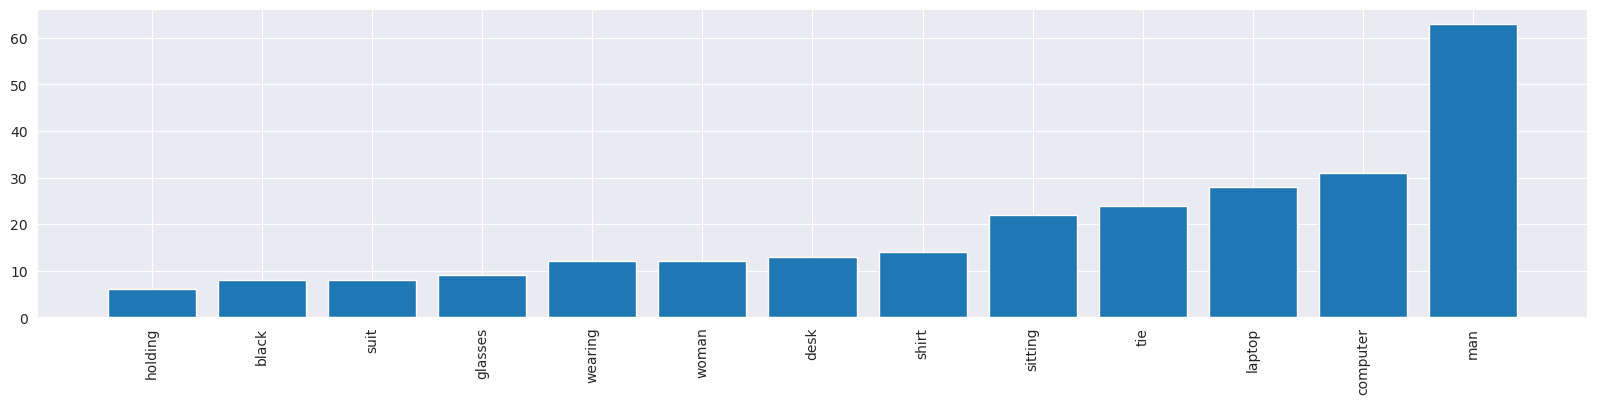

In [280]:
import seaborn as sns
sns.set_style("darkgrid")
word_dict_pruned = dict(sorted(word_dict_pruned.items(), key=lambda item: item[1]))
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
plt.bar(word_dict_pruned.keys(),word_dict_pruned.values())

In [166]:
word_dict_pruned[""]

111

In [292]:
j = 0
for i in range(100):
    key_ = f'computer programmer/{i}'
    if key_ in captions_google:
#         if "chef" in captions_google[key_][0].replace(".", "").split(" "):
#             comp = True
#         else:
#             comp = False
        print(i, captions_google[key_])
        j += 1

1 ['A man sitting at a desk using a laptop computer.']
2 ['A man sitting at a desk using a laptop computer.']
3 ["A collage of a boy's head and a computer keyboard."]
4 ['A picture of a computer keyboard and mouse.']
6 ['A man in a black and white uniform working on a laptop.']
7 ['A man in a yellow shirt is working on a telephone.']
8 ['A man sitting at a table with a laptop computer.']
9 ['A man sitting at a desk with a laptop and a tablet.']
11 ['A man is shown with his face in a mirror.']
12 ['A man in a computer lab looking at a computer screen.']
15 ['A man sitting on the ground with his legs crossed and a laptop in his lap.']
16 ['A picture of a man with a laptop computer.']
17 ['Two men sitting at a table with laptops.']
19 ['A man sitting at a desk typing on a keyboard.']
22 ['A woman sitting at a desk with a computer and a laptop.']
25 ['A drawing of a calculator with a bunch of numbers on it.']
26 ['A woman sitting at a desk with a computer.']
27 ['A woman is working on a co

In [ ]:
def convert_gn(s):
    word_translate = { 'woman': 'person', 'gentleman': 'person', 'lady': 'person','guy': 'person', 'men and women': 'people', 'women and men': 'people', 'boys and girls': 'children', 'girls and boys': 'children', 'boys': 'children', 'girls': 'children','gentlemen': 'people', 'women': 'people', 'ladies': 'people', 'man': 'person', 'boy': 'child', 'girl': 'child', 'men': 'people', 'his': 'their','her':'their', 'he':'they', 'she':'they' , 'male': "", 'female': "", 'himself':'themselves', 'herself': 'themselves'}
    s = s.lower()
    words_captions = s.replace(".", "").split(" ")
    for k,v in word_translate.items():
        if k in words_captions:
            idxs = [i for i,x in enumerate(words_captions) if x==k]
            for idx in idxs:
                words_captions[idx] = v
    words_captions[-1] = words_captions[-1] + "."
    return " ".join(words_captions)

In [27]:
convert_gn('a male guy are a guy carrying he coat.')

'a  person are a person carrying they coat.'